In [1]:
import json

with open('data/stimuli.json', 'r', encoding='utf-8') as f:
    words = sum(json.load(f).values(), [])

In [2]:
import gspread

gc = gspread.service_account('.streamlit/streamlit-442717-4a22eb111230.json')
sheet = gc.open('SJT-results')

In [186]:
import pandas as pd
from gspread_dataframe import get_as_dataframe

dfs: dict[str, pd.DataFrame] = {}

for ws in sheet.worksheets():
    df = get_as_dataframe(ws)

    if df.shape != (len(words), len(words) + 1):
        continue

    name = ws.title.split('_')[0]

    if name in dfs:
        name = ws.title

    dfs[name] = df.set_index(df.columns[0])


In [187]:
import numpy as np

dfs['Average'] = pd.DataFrame(
    data=np.mean(
        [df.to_numpy() for df in dfs.values()],
        axis=0
    ),
    index=pd.Index(words),
    columns=pd.Index(words)
)

  0%|          | 0/4 [00:00<?, ?it/s]/mnt/Shared/FMFI/2425/ZS/ITP/project/sjt-streamlit/venv/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector
 25%|██▌       | 1/4 [00:03<00:11,  3.73s/it]/mnt/Shared/FMFI/2425/ZS/ITP/project/sjt-streamlit/venv/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector
 50%|█████     | 2/4 [00:06<00:06,  3.37s/it]/mnt/Shared/FMFI/2425/ZS/ITP/project/sjt-streamlit/venv/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector
 75%|███████▌  | 3/4 [00:09<00:03,  3.18s/it]/mnt/Shared/FMFI/2425/ZS/ITP/project/sjt-streamlit/venv/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v 

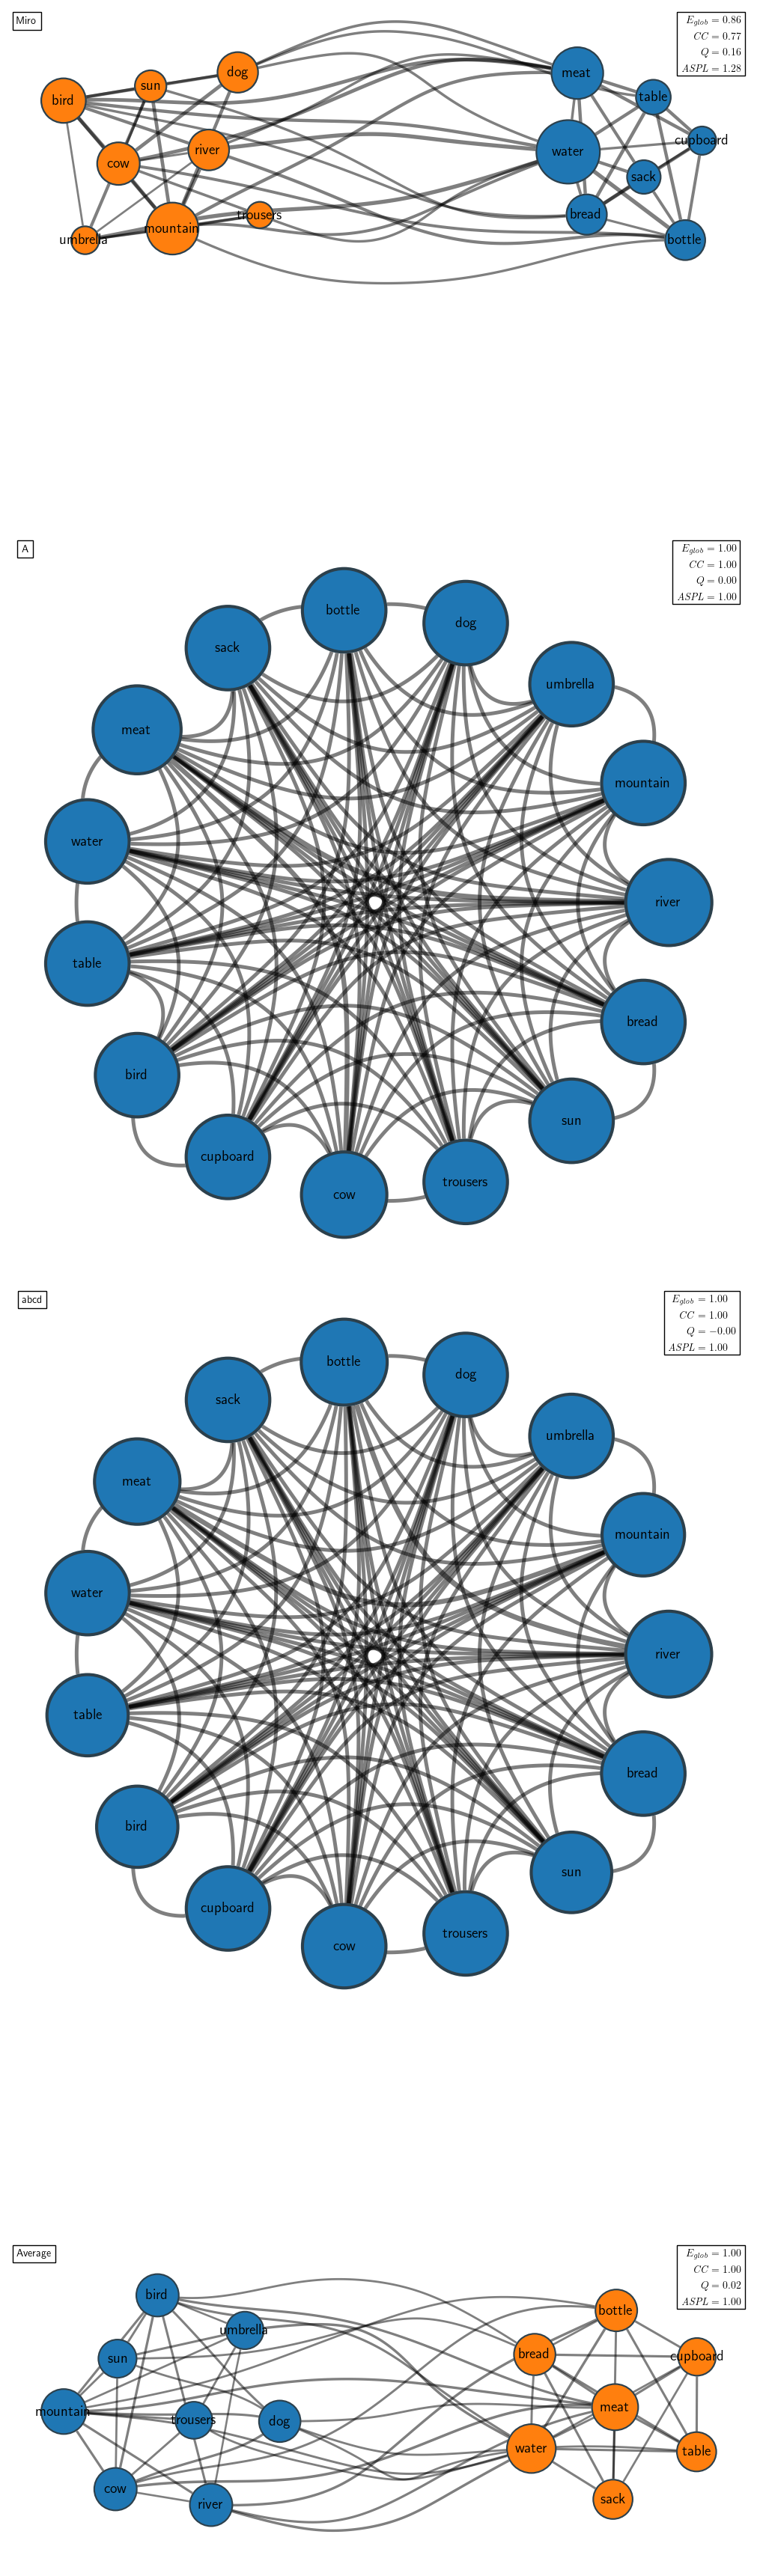

In [222]:
import itertools

import matplotlib.pyplot as plt
import networkx as nx
import netgraph as ng
from matplotlib.offsetbox import AnchoredText
from networkx.algorithms.efficiency_measures import global_efficiency
from networkx.algorithms.approximation.clustering_coefficient import average_clustering
from networkx.algorithms.community import modularity, louvain_communities
from networkx.algorithms.shortest_paths import average_shortest_path_length
from tqdm import tqdm

custom_preamble = {
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath}'
}
plt.rcParams.update(custom_preamble)

fig, axs = plt.subplots(nrows=len(dfs), figsize=(10, 10 * len(dfs)), layout='constrained')

for i, name in enumerate(tqdm(dfs)):
    g = nx.Graph()
    adj = dfs[name]

    for u, v in itertools.combinations(words, 2):
        weight = adj.at[u, v]

        if weight > 0.0:
            g.add_edge(u, v, weight=weight)

    communities = louvain_communities(g, weight='weight')

    e_glob = global_efficiency(g)
    cc = average_clustering(g)
    q = modularity(g, communities, weight='weight')
    aspl = average_shortest_path_length(g, weight=None)

    node_to_community = {
        w: community_id
        for community_id, community in enumerate(communities)
        for w in community
    }
    community_to_color = {
        0: 'tab:blue',
        1: 'tab:orange',
        2: 'tab:green',
        3: 'tab:red',
    }
    node_color = {
        node: community_to_color[community_id]
        for node, community_id in node_to_community.items()
    }
    node_sizes = {
        node: sum([d['weight'] for *_, d in g.edges(node, data=True)])
        for node in g.nodes
    }

    edge_widths = {
        (u, v): (d['weight'] * 1.2 if d['weight'] >= 0.5 else 0)
        for u, v, d in g.edges(data=True)
    }
    edge_colors = {
        (u, v): (d['weight'] * 0.75 if d['weight'] >= 0.5 else 0)
        for u, v, d in g.edges(data=True)
    }

    ng.Graph(
        graph=g,
        node_color=node_color,
        node_labels=True,
        node_label_fontdict=dict(size=14),
        node_edge_width=0.5,
        node_size=node_sizes,
        node_layout='community' if len(communities) >= 2 else 'circular',
        node_layout_kwargs=(
            dict(node_to_community=node_to_community, pad_by=1.2) 
            if len(communities) >= 2 else None
        ),
        edge_layout='curved',
        edge_width=edge_widths,
        edge_color='black',
        edge_alpha=0.5,
        prettify=True,
        ax=axs[i]
    )
    
    values = AnchoredText(
        s=(
            r'\begin{align*} '
            rf'E_\mathit{{glob}} &= {e_glob:.2f}\\ '
            rf'\mathit{{CC}} &= {cc:.2f}\\ '
            rf'Q &= {q:.2f}\\ '
            rf'\mathit{{ASPL}} &= {aspl:.2f} '
            r'\end{align*}'
        ),
        loc='upper right',
        zorder=1000
    )
    axs[i].add_artist(values)
    axs[i].add_artist(AnchoredText(name, loc='upper left', zorder=1000))

plt.show()